In [6]:
%%writefile reduction_max.cu


#include <stdio.h>
#include <stdlib.h>
#include <cuda_runtime.h>
#include <algorithm>
#include <iostream>
#include <vector>

// Macro pour vérifier les erreurs CUDA
#define CUDA_CHECK(call) \
do { \
    cudaError_t error = call; \
    if (error != cudaSuccess) { \
        fprintf(stderr, "Erreur CUDA à %s:%d - %s\n", \
                __FILE__, __LINE__, \
                cudaGetErrorString(error)); \
        exit(EXIT_FAILURE); \
    } \
} while(0)

// Opération atomique max pour les flottants (pour CUDA < 11.0)
__device__ float atomicMaxFloat(float* address, float val) {
    int* address_as_int = (int*)address;
    int old = *address_as_int;
    int expected;
    do {
        expected = old;
        old = atomicCAS(address_as_int, expected, 
                         __float_as_int(max(val, __int_as_float(expected))));
    } while (expected != old);
    return __int_as_float(old);
}

// Fonction pour initialiser les données
void initializeData(float* data, size_t size) {
    for (size_t i = 0; i < size; i++) {
        data[i] = static_cast<float>(rand()) / RAND_MAX * 100.0f;
    }
    // Ajouter une valeur maximale connue pour vérifier la correction
    size_t index = rand() % size;
    data[index] = 999.0f;
}

// Implémentation CPU pour la validation
float findMaxCPU(float* data, size_t size) {
    float maxVal = data[0];
    for (size_t i = 1; i < size; i++) {
        maxVal = std::max(maxVal, data[i]);
    }
    return maxVal;
}

// ===== Méthode 1: Réduction naïve avec mémoire globale uniquement =====
__global__ void reduceMaxNaive(float* input, float* output, int size) {
    int tid = blockIdx.x * blockDim.x + threadIdx.x;
    int gridSize = blockDim.x * gridDim.x;
    
    // Initialiser le maximum local
    float localMax = -INFINITY;
    
    // Parcours par stride pour traiter les tableaux plus grands que la grille
    for (int i = tid; i < size; i += gridSize) {
        localMax = max(localMax, input[i]);
    }
    
    // Utiliser une opération atomique pour mettre à jour le maximum global
    if (localMax > -INFINITY) {
        atomicMaxFloat(&output[0], localMax);
    }
}

// ===== Méthode 2: Réduction utilisant la mémoire partagée avec synchronisation =====
__global__ void reduceMaxShared(float* input, float* output, int size) {
    extern __shared__ float sdata[];
    
    int tid = threadIdx.x;
    int i = blockIdx.x * blockDim.x + threadIdx.x;
    
    // Initialiser la mémoire partagée
    sdata[tid] = -INFINITY;
    
    // Charger les données dans la mémoire partagée
    if (i < size) {
        sdata[tid] = input[i];
    }
    __syncthreads();
    
    // Réduction dans la mémoire partagée
    for (int s = blockDim.x / 2; s > 0; s >>= 1) {
        if (tid < s) {
            sdata[tid] = max(sdata[tid], sdata[tid + s]);
        }
        __syncthreads();
    }
    
    // Écrire le résultat de ce bloc dans la mémoire globale
    if (tid == 0) {
        atomicMaxFloat(&output[0], sdata[0]);
    }
}

// ===== Méthode 3: Réduction en 2 étapes : intra-bloc puis inter-bloc =====
__global__ void reduceMaxTwoStep_step1(float* input, float* blockResults, int size) {
    extern __shared__ float sdata[];
    
    int tid = threadIdx.x;
    int i = blockIdx.x * blockDim.x + threadIdx.x;
    
    // Initialiser la mémoire partagée
    sdata[tid] = -INFINITY;
    
    // Charger les données dans la mémoire partagée
    if (i < size) {
        sdata[tid] = input[i];
    }
    __syncthreads();
    
    // Réduction dans la mémoire partagée
    for (int s = blockDim.x / 2; s > 0; s >>= 1) {
        if (tid < s) {
            sdata[tid] = max(sdata[tid], sdata[tid + s]);
        }
        __syncthreads();
    }
    
    // Écrire le résultat de ce bloc dans la mémoire globale
    if (tid == 0) {
        blockResults[blockIdx.x] = sdata[0];
    }
}

__global__ void reduceMaxTwoStep_step2(float* blockResults, float* output, int numBlocks) {
    extern __shared__ float sdata[];
    
    int tid = threadIdx.x;
    
    // Initialiser la mémoire partagée
    sdata[tid] = -INFINITY;
    
    // Charger les résultats des blocs dans la mémoire partagée
    if (tid < numBlocks) {
        sdata[tid] = blockResults[tid];
    }
    __syncthreads();
    
    // Réduction dans la mémoire partagée
    for (int s = blockDim.x / 2; s > 0; s >>= 1) {
        if (tid < s) {
            sdata[tid] = max(sdata[tid], sdata[tid + s]);
        }
        __syncthreads();
    }
    
    // Écrire le résultat final
    if (tid == 0) {
        output[0] = sdata[0];
    }
}

// ===== Méthode 4: Réduction avec registres internes (niveau thread) =====
__global__ void reduceMaxRegisters(float* input, float* output, int size) {
    int tid = blockIdx.x * blockDim.x + threadIdx.x;
    int gridSize = blockDim.x * gridDim.x;
    
    // Chaque thread maintient un maximum local dans un registre
    float localMax = -INFINITY;
    
    // Parcours par stride pour traiter les tableaux plus grands que la grille
    for (int i = tid; i < size; i += gridSize) {
        localMax = max(localMax, input[i]);
    }
    
    // Stocker dans la mémoire partagée pour la réduction au niveau bloc
    extern __shared__ float sdata[];
    int ltid = threadIdx.x;
    sdata[ltid] = localMax;
    __syncthreads();
    
    // Réduction au niveau bloc
    for (int s = blockDim.x / 2; s > 0; s >>= 1) {
        if (ltid < s) {
            sdata[ltid] = max(sdata[ltid], sdata[ltid + s]);
        }
        __syncthreads();
    }
    
    // Écrire le résultat du bloc dans la mémoire globale
    if (ltid == 0) {
        atomicMaxFloat(&output[0], sdata[0]);
    }
}


// Fonction pour exécuter et chronométrer la méthode naïve
void runNaiveMethod(float* d_input, float* d_output, float* h_output, int size) {
    // Configurer les paramètres de lancement du kernel
    int blockSize = 256;
    int gridSize = (size + blockSize - 1) / blockSize;
    gridSize = std::min(gridSize, 1024); // Limiter la taille de la grille
    
    // Réinitialiser la sortie
    float minusInf = -INFINITY;
    CUDA_CHECK(cudaMemcpy(d_output, &minusInf, sizeof(float), cudaMemcpyHostToDevice));
    
    // Créer des événements CUDA pour la chronométrie
    cudaEvent_t start, stop;
    CUDA_CHECK(cudaEventCreate(&start));
    CUDA_CHECK(cudaEventCreate(&stop));
    
    // Exécution de préchauffe
    reduceMaxNaive<<<gridSize, blockSize>>>(d_input, d_output, size);
    CUDA_CHECK(cudaGetLastError());
    CUDA_CHECK(cudaDeviceSynchronize());
    
    // Exécution chronométrée
    CUDA_CHECK(cudaEventRecord(start));
    reduceMaxNaive<<<gridSize, blockSize>>>(d_input, d_output, size);
    CUDA_CHECK(cudaGetLastError());
    CUDA_CHECK(cudaEventRecord(stop));
    CUDA_CHECK(cudaEventSynchronize(stop));
    
    // Copier le résultat vers l'hôte
    CUDA_CHECK(cudaMemcpy(h_output, d_output, sizeof(float), cudaMemcpyDeviceToHost));
    
    // Calculer le temps écoulé
    float milliseconds = 0;
    CUDA_CHECK(cudaEventElapsedTime(&milliseconds, start, stop));
    
    // Afficher les résultats
    printf("Méthode naïve avec mémoire globale: %.3f ms\n", milliseconds);
    
    // Nettoyage
    CUDA_CHECK(cudaEventDestroy(start));
    CUDA_CHECK(cudaEventDestroy(stop));
}

// Fonction pour exécuter et chronométrer la méthode avec mémoire partagée
void runSharedMethod(float* d_input, float* d_output, float* h_output, int size) {
    // Configurer les paramètres de lancement du kernel
    int blockSize = 256;
    int gridSize = (size + blockSize - 1) / blockSize;
    gridSize = std::min(gridSize, 1024); // Limiter la taille de la grille
    
    // Créer des événements CUDA pour la chronométrie
    cudaEvent_t start, stop;
    CUDA_CHECK(cudaEventCreate(&start));
    CUDA_CHECK(cudaEventCreate(&stop));
    
    // Exécution de préchauffe
    reduceMaxShared<<<gridSize, blockSize, blockSize * sizeof(float)>>>(d_input, d_output, size);
    CUDA_CHECK(cudaGetLastError());
    CUDA_CHECK(cudaDeviceSynchronize());
    
    // Exécution chronométrée
    CUDA_CHECK(cudaEventRecord(start));
    reduceMaxShared<<<gridSize, blockSize, blockSize * sizeof(float)>>>(d_input, d_output, size);
    CUDA_CHECK(cudaGetLastError());
    CUDA_CHECK(cudaEventRecord(stop));
    CUDA_CHECK(cudaEventSynchronize(stop));
    
    // Trouver le maximum des résultats de bloc sur le CPU
    float* blockResults = new float[gridSize];
    CUDA_CHECK(cudaMemcpy(blockResults, d_output, gridSize * sizeof(float), cudaMemcpyDeviceToHost));
    
    h_output[0] = blockResults[0];
    for (int i = 1; i < gridSize; i++) {
        h_output[0] = std::max(h_output[0], blockResults[i]);
    }
    
    // Calculer le temps écoulé
    float milliseconds = 0;
    CUDA_CHECK(cudaEventElapsedTime(&milliseconds, start, stop));
    
    // Afficher les résultats
    printf("Réduction avec mémoire partagée: %.3f ms\n", milliseconds);
    
    // Nettoyage
    CUDA_CHECK(cudaEventDestroy(start));
    CUDA_CHECK(cudaEventDestroy(stop));
    delete[] blockResults;
}

// Fonction pour exécuter et chronométrer la méthode en deux étapes
void runTwoStepMethod(float* d_input, float* d_output, float* h_output, int size) {
    // Configurer les paramètres de lancement du kernel
    int blockSize = 256;
    int gridSize = (size + blockSize - 1) / blockSize;
    gridSize = std::min(gridSize, 1024); // Limiter la taille de la grille
    
    // Allouer de la mémoire pour les résultats intermédiaires
    float* d_blockResults;
    CUDA_CHECK(cudaMalloc(&d_blockResults, gridSize * sizeof(float)));
    
    // Créer des événements CUDA pour la chronométrie
    cudaEvent_t start, stop;
    CUDA_CHECK(cudaEventCreate(&start));
    CUDA_CHECK(cudaEventCreate(&stop));
    
    // Exécution de préchauffe
    reduceMaxTwoStep_step1<<<gridSize, blockSize, blockSize * sizeof(float)>>>(d_input, d_blockResults, size);
    reduceMaxTwoStep_step2<<<1, 256, 256 * sizeof(float)>>>(d_blockResults, d_output, gridSize);
    CUDA_CHECK(cudaGetLastError());
    CUDA_CHECK(cudaDeviceSynchronize());
    
    // Exécution chronométrée
    CUDA_CHECK(cudaEventRecord(start));
    reduceMaxTwoStep_step1<<<gridSize, blockSize, blockSize * sizeof(float)>>>(d_input, d_blockResults, size);
    reduceMaxTwoStep_step2<<<1, 256, 256 * sizeof(float)>>>(d_blockResults, d_output, gridSize);
    CUDA_CHECK(cudaGetLastError());
    CUDA_CHECK(cudaEventRecord(stop));
    CUDA_CHECK(cudaEventSynchronize(stop));
    
    // Copier le résultat vers l'hôte
    CUDA_CHECK(cudaMemcpy(h_output, d_output, sizeof(float), cudaMemcpyDeviceToHost));
    
    // Calculer le temps écoulé
    float milliseconds = 0;
    CUDA_CHECK(cudaEventElapsedTime(&milliseconds, start, stop));
    
    // Afficher les résultats
    printf("Réduction en 2 étapes: %.3f ms\n", milliseconds);
    
    // Nettoyage
    CUDA_CHECK(cudaEventDestroy(start));
    CUDA_CHECK(cudaEventDestroy(stop));
    CUDA_CHECK(cudaFree(d_blockResults));
}

// Fonction pour exécuter et chronométrer la méthode avec registres
void runRegistersMethod(float* d_input, float* d_output, float* h_output, int size) {
    // Configurer les paramètres de lancement du kernel
    int blockSize = 256;
    int gridSize = (size + blockSize - 1) / blockSize;
    gridSize = std::min(gridSize, 1024); // Limiter la taille de la grille
    
    // Réinitialiser la sortie
    float minusInf = -INFINITY;
    CUDA_CHECK(cudaMemcpy(d_output, &minusInf, sizeof(float), cudaMemcpyHostToDevice));
    
    // Créer des événements CUDA pour la chronométrie
    cudaEvent_t start, stop;
    CUDA_CHECK(cudaEventCreate(&start));
    CUDA_CHECK(cudaEventCreate(&stop));
    
    // Exécution de préchauffe
    reduceMaxRegisters<<<gridSize, blockSize, blockSize * sizeof(float)>>>(d_input, d_output, size);
    CUDA_CHECK(cudaGetLastError());
    CUDA_CHECK(cudaDeviceSynchronize());
    
    // Exécution chronométrée
    CUDA_CHECK(cudaEventRecord(start));
    reduceMaxRegisters<<<gridSize, blockSize, blockSize * sizeof(float)>>>(d_input, d_output, size);
    CUDA_CHECK(cudaGetLastError());
    CUDA_CHECK(cudaEventRecord(stop));
    CUDA_CHECK(cudaEventSynchronize(stop));
    
    // Copier le résultat vers l'hôte
    CUDA_CHECK(cudaMemcpy(h_output, d_output, sizeof(float), cudaMemcpyDeviceToHost));
    
    // Calculer le temps écoulé
    float milliseconds = 0;
    CUDA_CHECK(cudaEventElapsedTime(&milliseconds, start, stop));
    
    // Afficher les résultats
    printf("Réduction avec registres internes: %.3f ms\n", milliseconds);
    
    // Nettoyage
    CUDA_CHECK(cudaEventDestroy(start));
    CUDA_CHECK(cudaEventDestroy(stop));
}

int main() {
    // Définir la graine aléatoire pour la reproductibilité
    srand(42);
    
    // Obtenir les propriétés du périphérique
    cudaDeviceProp prop;
    CUDA_CHECK(cudaGetDeviceProperties(&prop, 0));
    printf("Périphérique: %s\n", prop.name);
    printf("Capacité de calcul: %d.%d\n", prop.major, prop.minor);
    
    // Tester différentes tailles de tableau
    std::vector<int> sizes = {1000, 10000, 100000, 1000000, 10000000};
    
    for (size_t s = 0; s < sizes.size(); s++) {
        int size = sizes[s];
        printf("\n---------------\n");
        printf("Taille du tableau: %d\n", size);
        printf("---------------\n");
        
        // Allouer la mémoire hôte et initialiser les données
        float* h_input = new float[size];
        float h_output[5] = {0}; // Un pour chaque méthode
        
        initializeData(h_input, size);
        float maxValueCPU = findMaxCPU(h_input, size);
        
        // Allouer la mémoire device
        float* d_input;
        float* d_output;
        CUDA_CHECK(cudaMalloc(&d_input, size * sizeof(float)));
        CUDA_CHECK(cudaMalloc(&d_output, size * sizeof(float))); // Allouer assez pour le pire cas
        
        // Copier les données d'entrée vers le device
        CUDA_CHECK(cudaMemcpy(d_input, h_input, size * sizeof(float), cudaMemcpyHostToDevice));
        
        // Exécuter la validation CPU
        printf("Valeur max CPU: %.1f\n\n", maxValueCPU);
        
        // Exécuter les benchmarks
        runNaiveMethod(d_input, d_output, &h_output[0], size);
        printf("Résultat: %.1f (Correct: %s)\n\n", h_output[0], 
               (fabs(h_output[0] - maxValueCPU) < 1e-5) ? "Oui" : "Non");
        
        runSharedMethod(d_input, d_output, &h_output[1], size);
        printf("Résultat: %.1f (Correct: %s)\n\n", h_output[1], 
               (fabs(h_output[1] - maxValueCPU) < 1e-5) ? "Oui" : "Non");
        
        runTwoStepMethod(d_input, d_output, &h_output[2], size);
        printf("Résultat: %.1f (Correct: %s)\n\n", h_output[2], 
               (fabs(h_output[2] - maxValueCPU) < 1e-5) ? "Oui" : "Non");
        
        runRegistersMethod(d_input, d_output, &h_output[3], size);
        printf("Résultat: %.1f (Correct: %s)\n\n", h_output[3], 
               (fabs(h_output[3] - maxValueCPU) < 1e-5) ? "Oui" : "Non");
        
        // Libérer la mémoire
        delete[] h_input;
        CUDA_CHECK(cudaFree(d_input));
        CUDA_CHECK(cudaFree(d_output));
    }
    
    return 0;
}

Overwriting reduction_max.cu


In [9]:
!nvcc -o reduction_max reduction_max.cu -std=c++11
!./reduction_max > results.txt

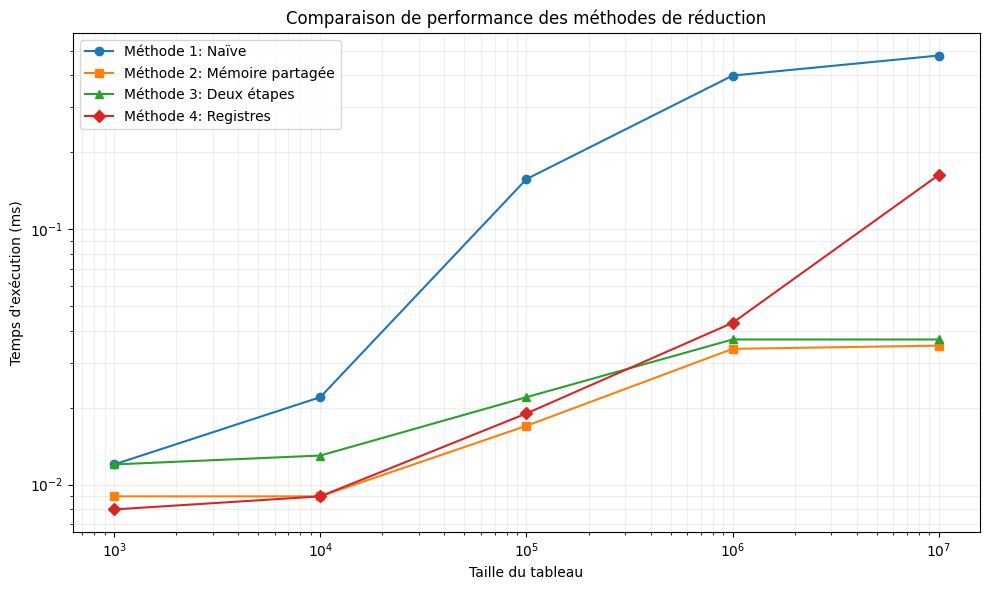

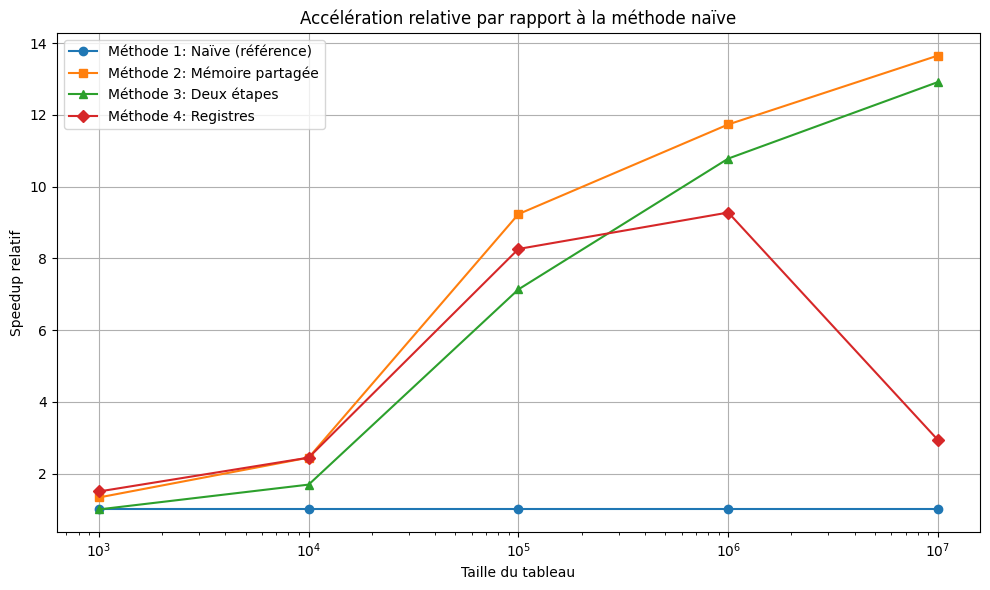

<Figure size 1200x600 with 0 Axes>

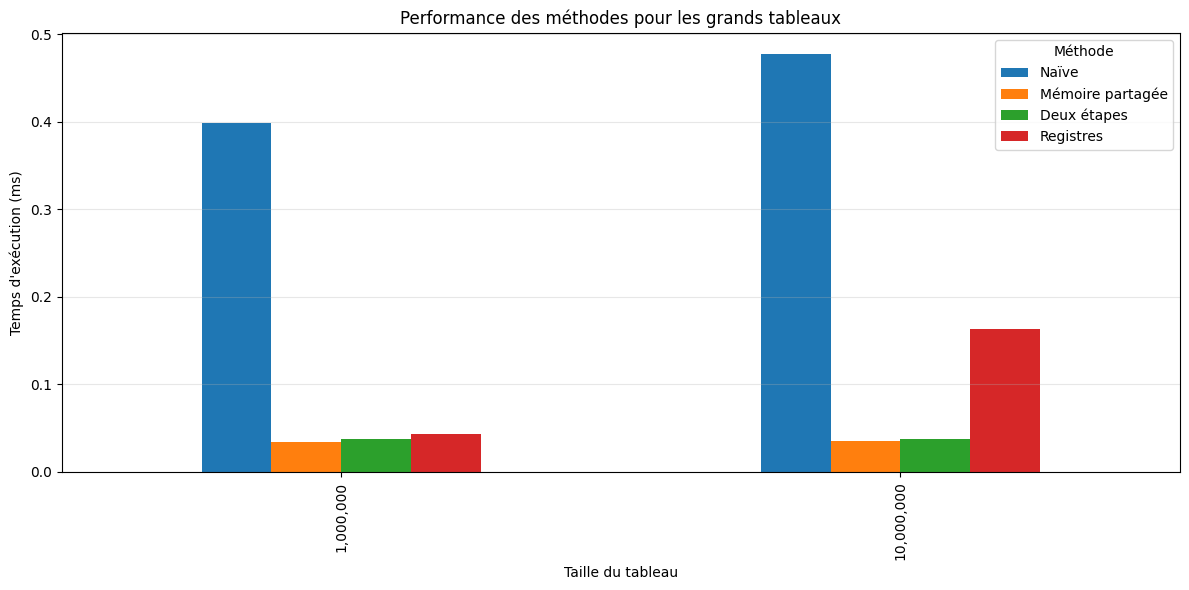

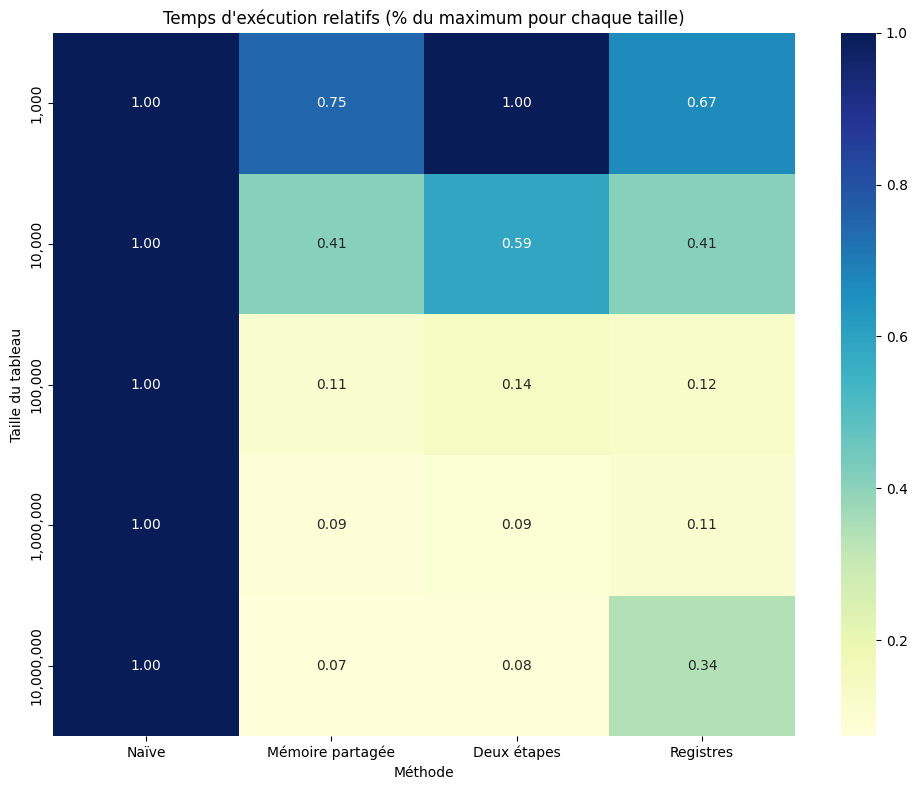

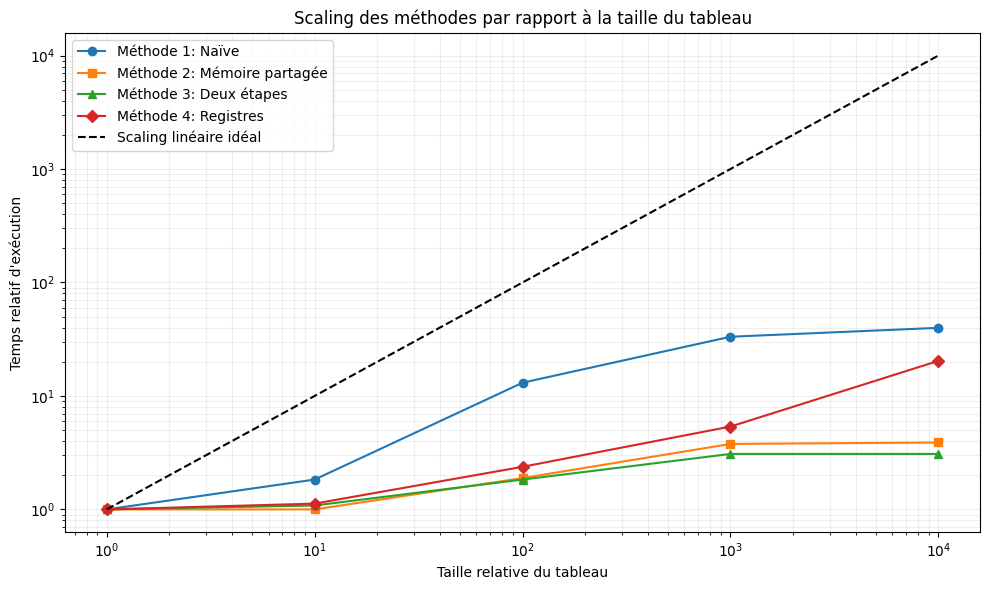

Tableau des temps d'exécution (ms):
  Taille  Naïve  Mémoire partagée  Deux étapes  Registres
    1000  0.012             0.009        0.012      0.008
   10000  0.022             0.009        0.013      0.009
  100000  0.157             0.017        0.022      0.019
 1000000  0.399             0.034        0.037      0.043
10000000  0.478             0.035        0.037      0.163

Tableau des accélérations relatives (par rapport à la méthode naïve):
  Taille  Speedup Mémoire partagée  Speedup Deux étapes  Speedup Registres
    1000                  1.333333             1.000000           1.500000
   10000                  2.444444             1.692308           2.444444
  100000                  9.235294             7.136364           8.263158
 1000000                 11.735294            10.783784           9.279070
10000000                 13.657143            12.918919           2.932515


In [10]:
import matplotlib.pyplot as plt
import numpy as np
import re
import pandas as pd
import seaborn as sns

# Fonction pour extraire les temps d'exécution des résultats
def extract_execution_times(file_path="results.txt"):
    with open(file_path, 'r') as f:
        content = f.read()
    
    # Structure pour stocker les résultats
    results = {
        'sizes': [],
        'naive': [],
        'shared': [],
        'two_step': [],
        'registers': []
    }
    
    # Expression régulière pour extraire les tailles de tableau
    size_pattern = r"Taille du tableau: (\d+)"
    sizes = re.findall(size_pattern, content)
    results['sizes'] = [int(size) for size in sizes]
    
    # Expressions régulières pour extraire les temps d'exécution de chaque méthode
    naive_pattern = r"Méthode naïve avec mémoire globale: ([\d.]+) ms"
    shared_pattern = r"Réduction avec mémoire partagée: ([\d.]+) ms"
    two_step_pattern = r"Réduction en 2 étapes: ([\d.]+) ms"
    registers_pattern = r"Réduction avec registres internes: ([\d.]+) ms"
    
    # Trouver toutes les occurrences de chaque pattern
    naive_times = re.findall(naive_pattern, content)
    shared_times = re.findall(shared_pattern, content)
    two_step_times = re.findall(two_step_pattern, content)
    registers_times = re.findall(registers_pattern, content)
    
    # Convertir en float
    results['naive'] = [float(t) for t in naive_times]
    results['shared'] = [float(t) for t in shared_times]
    results['two_step'] = [float(t) for t in two_step_times]
    results['registers'] = [float(t) for t in registers_times]
    
    return results

# Extraire les résultats
results = extract_execution_times()

# 1. Graphique de performance brute
plt.figure(figsize=(10, 6))
plt.plot(results['sizes'], results['naive'], 'o-', label='Méthode 1: Naïve')
plt.plot(results['sizes'], results['shared'], 's-', label='Méthode 2: Mémoire partagée')
plt.plot(results['sizes'], results['two_step'], '^-', label='Méthode 3: Deux étapes')
plt.plot(results['sizes'], results['registers'], 'D-', label='Méthode 4: Registres')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Taille du tableau')
plt.ylabel('Temps d\'exécution (ms)')
plt.title('Comparaison de performance des méthodes de réduction')
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.legend()
plt.tight_layout()
plt.savefig('performance_comparison.png')
plt.show()

# 2. Graphique du speedup relatif par rapport à la méthode naïve
plt.figure(figsize=(10, 6))
speedup_shared = [n/s if s > 0 else 0 for n, s in zip(results['naive'], results['shared'])]
speedup_two_step = [n/t if t > 0 else 0 for n, t in zip(results['naive'], results['two_step'])]
speedup_registers = [n/r if r > 0 else 0 for n, r in zip(results['naive'], results['registers'])]

plt.plot(results['sizes'], [1]*len(results['sizes']), 'o-', label='Méthode 1: Naïve (référence)')
plt.plot(results['sizes'], speedup_shared, 's-', label='Méthode 2: Mémoire partagée')
plt.plot(results['sizes'], speedup_two_step, '^-', label='Méthode 3: Deux étapes')
plt.plot(results['sizes'], speedup_registers, 'D-', label='Méthode 4: Registres')

plt.xscale('log')
plt.xlabel('Taille du tableau')
plt.ylabel('Speedup relatif')
plt.title('Accélération relative par rapport à la méthode naïve')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig('relative_speedup.png')
plt.show()

# 3. Graphique à barres pour comparer les méthodes sur les grandes tailles
plt.figure(figsize=(12, 6))
# Prendre les deux plus grandes tailles
large_sizes = results['sizes'][-2:]
methods = ['Naïve', 'Mémoire partagée', 'Deux étapes', 'Registres']

# Préparation des données
data = []
for i, size in enumerate(large_sizes):
    size_index = results['sizes'].index(size)
    data.append([
        results['naive'][size_index],
        results['shared'][size_index],
        results['two_step'][size_index],
        results['registers'][size_index]
    ])

# Création du DataFrame
df = pd.DataFrame(data, columns=methods)
df.index = [f"{size:,}" for size in large_sizes]

# Plot
ax = df.plot(kind='bar', figsize=(12, 6))
plt.xlabel('Taille du tableau')
plt.ylabel('Temps d\'exécution (ms)')
plt.title('Performance des méthodes pour les grands tableaux')
plt.legend(title='Méthode')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('large_arrays_comparison.png')
plt.show()

# 4. Heatmap des temps relatifs
# Normaliser chaque ligne par le maximum de la ligne
relative_times = np.zeros((len(results['sizes']), 4))
for i, size in enumerate(results['sizes']):
    times = [results['naive'][i], results['shared'][i], results['two_step'][i], results['registers'][i]]
    max_time = max(times)
    relative_times[i] = [t/max_time for t in times]

plt.figure(figsize=(10, 8))
heatmap_df = pd.DataFrame(relative_times, columns=methods)
heatmap_df.index = [f"{size:,}" for size in results['sizes']]

sns.heatmap(heatmap_df, annot=True, cmap="YlGnBu", fmt=".2f")
plt.xlabel('Méthode')
plt.ylabel('Taille du tableau')
plt.title('Temps d\'exécution relatifs (% du maximum pour chaque taille)')
plt.tight_layout()
plt.savefig('relative_performance_heatmap.png')
plt.show()

# 5. Analyse du scaling des méthodes
plt.figure(figsize=(10, 6))
# Normaliser par rapport à la plus petite taille
base_size = results['sizes'][0]
normalized_sizes = [s/base_size for s in results['sizes']]

naive_scaling = [t/results['naive'][0] for t in results['naive']]
shared_scaling = [t/results['shared'][0] for t in results['shared']]
two_step_scaling = [t/results['two_step'][0] for t in results['two_step']]
registers_scaling = [t/results['registers'][0] for t in results['registers']]

# Ligne de scaling linéal idéal
ideal_scaling = normalized_sizes

plt.loglog(normalized_sizes, naive_scaling, 'o-', label='Méthode 1: Naïve')
plt.loglog(normalized_sizes, shared_scaling, 's-', label='Méthode 2: Mémoire partagée')
plt.loglog(normalized_sizes, two_step_scaling, '^-', label='Méthode 3: Deux étapes')
plt.loglog(normalized_sizes, registers_scaling, 'D-', label='Méthode 4: Registres')
plt.loglog(normalized_sizes, ideal_scaling, 'k--', label='Scaling linéaire idéal')

plt.xlabel('Taille relative du tableau')
plt.ylabel('Temps relatif d\'exécution')
plt.title('Scaling des méthodes par rapport à la taille du tableau')
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.legend()
plt.tight_layout()
plt.savefig('scaling_analysis.png')
plt.show()

# Création d'un tableau de données de performance
performance_df = pd.DataFrame({
    'Taille': results['sizes'],
    'Naïve': results['naive'],
    'Mémoire partagée': results['shared'],
    'Deux étapes': results['two_step'],
    'Registres': results['registers']
})

# Afficher le tableau de performance
print("Tableau des temps d'exécution (ms):")
print(performance_df.to_string(index=False))

# Calculer les accélérations relatives
for method in ['Mémoire partagée', 'Deux étapes', 'Registres']:
    performance_df[f'Speedup {method}'] = performance_df['Naïve'] / performance_df[method]

print("\nTableau des accélérations relatives (par rapport à la méthode naïve):")
speedup_df = performance_df[['Taille', 'Speedup Mémoire partagée', 'Speedup Deux étapes', 'Speedup Registres']]
print(speedup_df.to_string(index=False))